In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob

np.set_printoptions(precision=3, suppress=True)

sin = np.sin
cos = np.cos
tan = np.tan
pi = np.pi


In [4]:
def interp2(v, xq, yq):
	dim_input = 1
	if len(xq.shape) == 2 or len(yq.shape) == 2:
		dim_input = 2
		q_h = xq.shape[0]
		q_w = xq.shape[1]
		xq = xq.flatten()
		yq = yq.flatten()

	h = v.shape[0]
	w = v.shape[1]
	if xq.shape != yq.shape:
		raise 'query coordinates Xq Yq should have same shape'

	x_floor = np.floor(xq).astype(np.int32)
	y_floor = np.floor(yq).astype(np.int32)
	x_ceil = np.ceil(xq).astype(np.int32)
	y_ceil = np.ceil(yq).astype(np.int32)

	x_floor[x_floor < 0] = 0
	y_floor[y_floor < 0] = 0
	x_ceil[x_ceil < 0] = 0
	y_ceil[y_ceil < 0] = 0

	x_floor[x_floor >= w-1] = w-1
	y_floor[y_floor >= h-1] = h-1
	x_ceil[x_ceil >= w-1] = w-1
	y_ceil[y_ceil >= h-1] = h-1

	v1 = v[y_floor, x_floor]
	v2 = v[y_floor, x_ceil]
	v3 = v[y_ceil, x_floor]
	v4 = v[y_ceil, x_ceil]

	lh = yq - y_floor
	lw = xq - x_floor
	hh = 1 - lh
	hw = 1 - lw

	w1 = hh * hw
	w2 = hh * lw
	w3 = lh * hw
	w4 = lh * lw

	interp_val = v1 * w1 + w2 * v2 + w3 * v3 + w4 * v4

	if dim_input == 2:
		return interp_val.reshape(q_h, q_w)
	return interp_val

# make a rotation matrix given axis x or y or z and angle
def make_rot_mat(axis, angle):
	if axis == 'x':
		return np.array([[1, 0, 0],
						 [0, cos(angle), -sin(angle)],
						 [0, sin(angle), cos(angle)]])
	if axis == 'y':
		return np.array([[cos(angle), 0, sin(angle)],
						 [0, 1, 0],
						 [-sin(angle), 0, cos(angle)]])
	if axis == 'z':
		return np.array([[cos(angle), -sin(angle), 0],
						 [sin(angle), cos(angle), 0],
						 [0, 0, 1]])
  
def parse_calibrations(calib_path):
	f = open(calib_path, 'r')
	calib = {}
	for line in f:
		line = line.strip()
		if line == '':
			continue
		key, value = line.split(':')
		value = np.array([float(v) for v in value.split()])
		calib[key] = value

	P2 = calib['P2'].reshape(3, 4)
	K = P2[:, :3]
	
	return K
  
def inverse_perspective_transform(image, K):
	R_x90 = make_rot_mat('x', pi/2)
	R_yn90 = make_rot_mat('y', -pi/2)
	R_cw = R_yn90 @ R_x90

	t_cw = np.array([0, 1.65, 0])

	X_cw = np.hstack((R_cw, t_cw.reshape(3, 1)))
	P_cw = K @ X_cw
	M = np.array([[1, 0, 0],
				[0, 1, 0],
				[0, 0, 0],
				[0, 0, 1]])
	PM = P_cw @ M

	image_width = image.shape[1]
	image_height = image.shape[0]

	q_cx, q_cy = np.meshgrid(np.arange(image_width), np.arange(image_height))
	q_c = np.stack((q_cx.flatten(), q_cy.flatten(), np.ones_like(q_cx.flatten())), axis=1).T

	q_r = np.linalg.inv(PM) @ q_c
	q_r = q_r / q_r[2, :]
	q_rx = q_r[0, :]
	q_ry = q_r[1, :]
	# clip values of q_rx
	q_rx = np.clip(q_rx, 1, 70)
	# clip values of q_ry
	q_ry = np.clip(q_ry, -15, 15)

	virtual_image_width = 1500
	virtual_image_height = 1500

	virtual_image = np.zeros((virtual_image_height, virtual_image_width, 3), dtype=np.uint8)
	q_rx, q_ry = np.meshgrid(np.linspace(np.min(q_rx), np.max(q_rx), virtual_image_width),
							np.linspace(np.min(q_ry), np.max(q_ry), virtual_image_height))
	q_r = np.stack((q_rx.flatten(), q_ry.flatten(), np.ones_like(q_rx.flatten())), axis=1).T
	q_c = PM @ q_r
	q_c = q_c / q_c[2, :]
	q_cx = q_c[0, :]
	q_cy = q_c[1, :]
	q_cx = q_cx.reshape(virtual_image_height, virtual_image_width)
	q_cy = q_cy.reshape(virtual_image_height, virtual_image_width)
	virtual_image[:,:,0] = interp2(image[:,:,0], q_cx, q_cy).T
	virtual_image[:,:,1] = interp2(image[:,:,1], q_cx, q_cy).T
	virtual_image[:,:,2] = interp2(image[:,:,2], q_cx, q_cy).T
	# flip virtual image upside down
	virtual_image = virtual_image[::-1, :, :]
	# flip virtual image left to right
	virtual_image = virtual_image[:, ::-1, :]
	# swap red and blue channels
	virtual_image = virtual_image[:, :, [2, 1, 0]]
	# crop
	virtual_image = virtual_image[:1200, :, :]
 
	return virtual_image

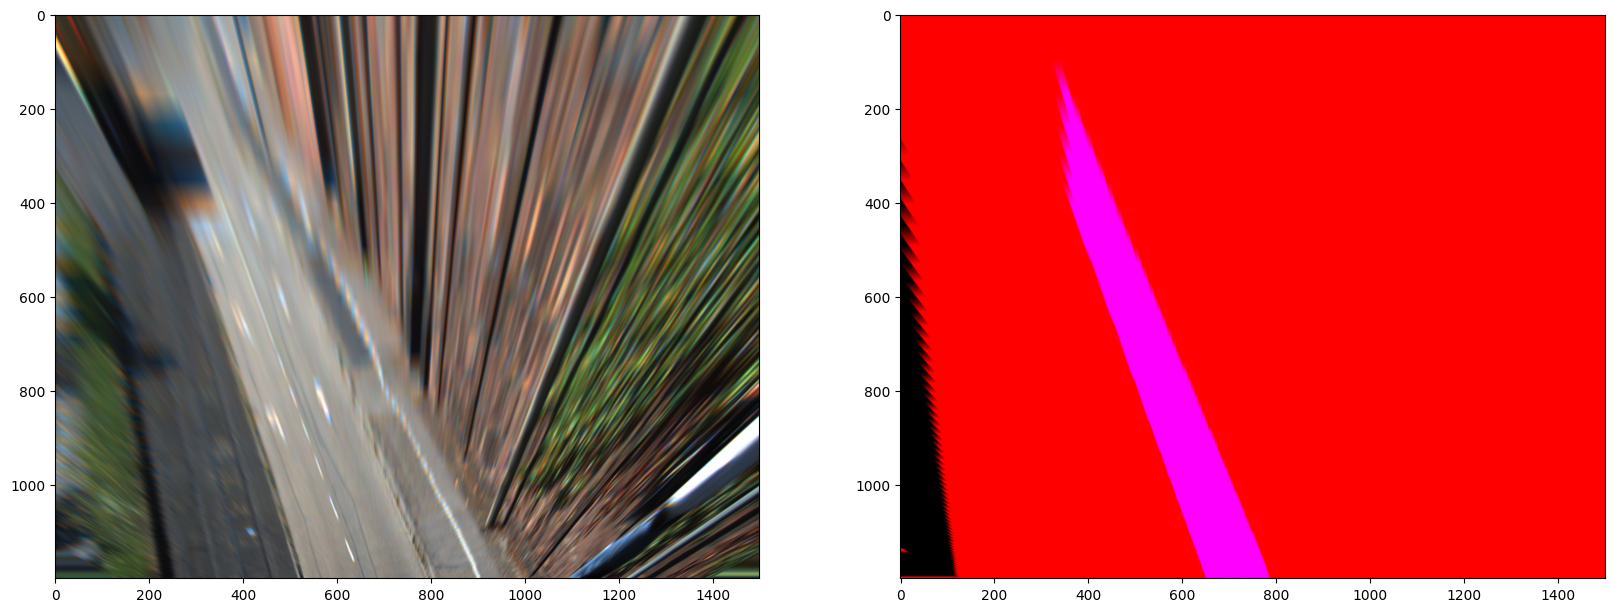

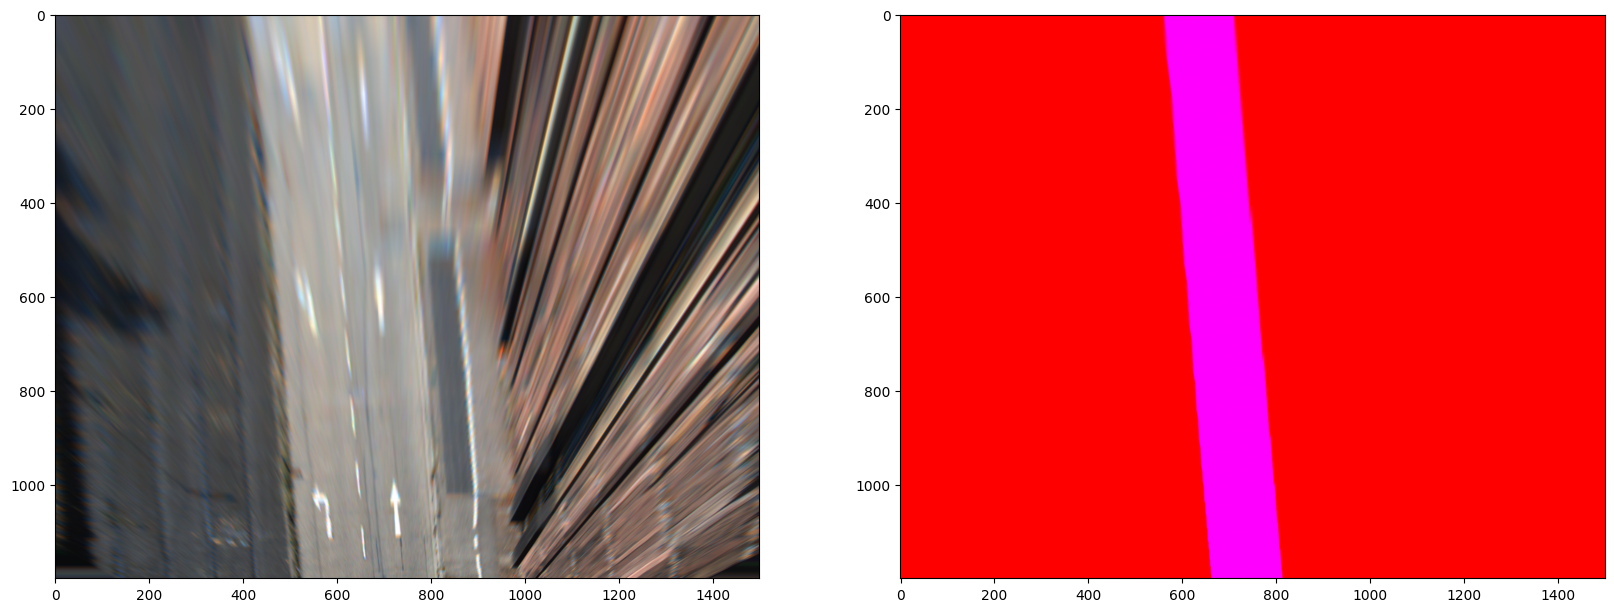

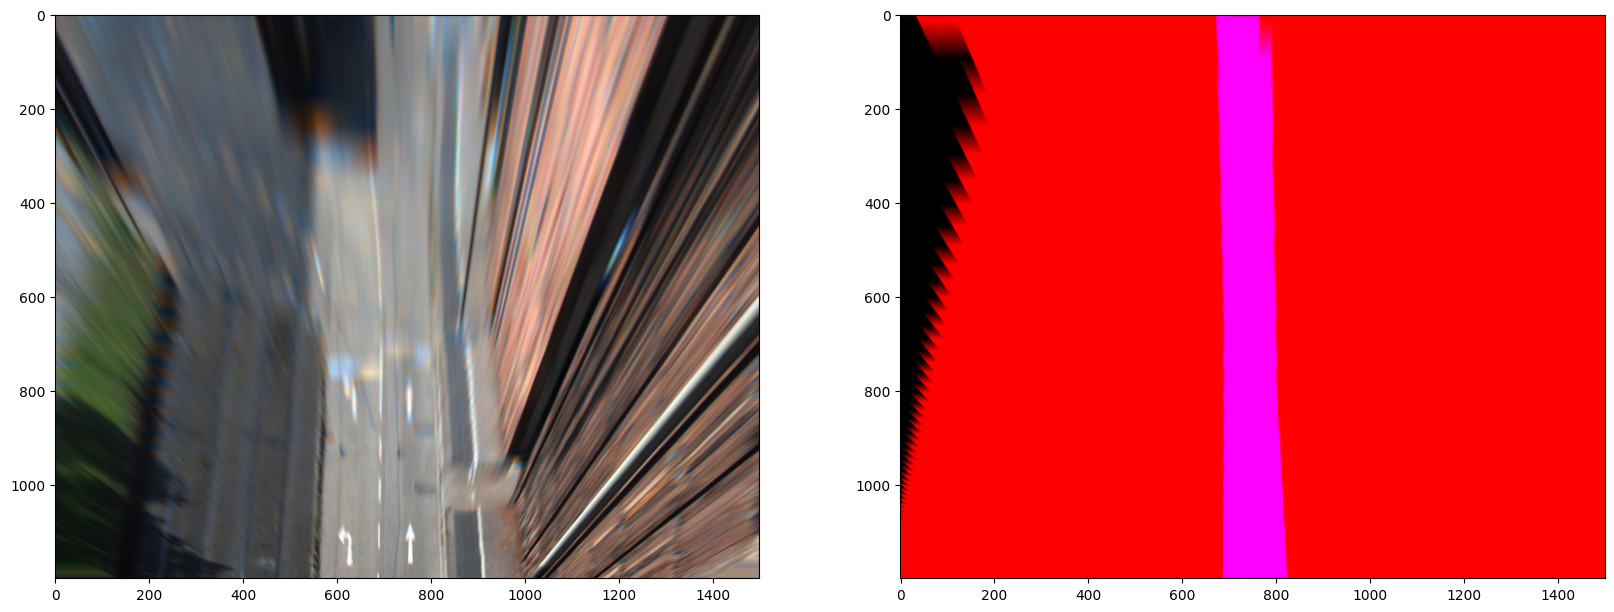

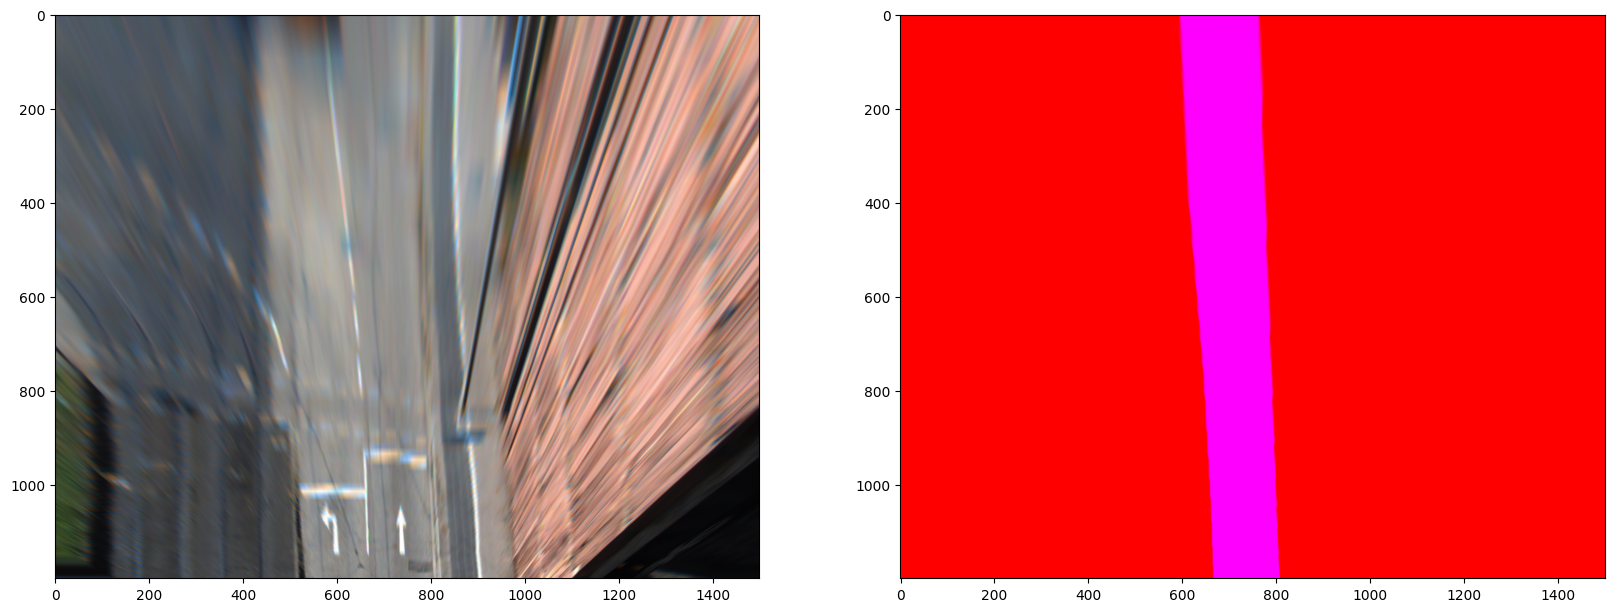

In [5]:
# load image & calibration

lane_images_path = 'lane_imgs'
rgb_images_path = 'rgb_imgs'

calib_path = 'calibration/um_000000.txt'
K = parse_calibrations(calib_path)

rgb_images = sorted(glob.glob(os.path.join(rgb_images_path, '*.png')))
lane_images = sorted(glob.glob(os.path.join(lane_images_path, '*.png')))

for rgb_image_path, lane_image_path in zip(rgb_images, lane_images):
    rgb_image = cv2.imread(rgb_image_path)
    lane_image = cv2.imread(lane_image_path)

    virtual_image_rgb = inverse_perspective_transform(rgb_image, K)
    virtual_image_lane = inverse_perspective_transform(lane_image, K)
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(virtual_image_rgb)
    plt.subplot(1, 2, 2)
    plt.imshow(virtual_image_lane)


In [4]:
"""
TODO:

- stitching/blending

- 360 degree views?
- 3D bounding boxes
- virtual objects in birdseye view
"""

'\nTODO:\n\n- stitching/blending\n\n- 360 degree views?\n- 3D bounding boxes\n- virtual objects in birdseye view\n'

In [1]:
import torch


In [6]:

from torchvision.models import detection
import pickle

if torch.cuda.is_available():
	device = torch.device('cuda')
elif torch.backends.mps.is_available():
	device = torch.device('cpu')
else:
    device = torch.device('cpu')

num_classes = 91

colors = np.random.uniform(0, 255, size=(num_classes, 3))

model = detection.retinanet_resnet50_fpn(pretrained=True, progress=True,
	num_classes=num_classes, pretrained_backbone=True).to(device)
model.eval()

for rgb_image_path, lane_image_path in zip(rgb_images, lane_images):
	frame = cv2.imread(rgb_image_path)
	orig = frame.copy()
	frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
	frame = frame.transpose((2, 0, 1))
	frame = np.expand_dims(frame, axis=0)
	frame = frame / 255.0
	frame = torch.FloatTensor(frame)
	# send the input to the device and pass the it through the
	# network to get the detections and predictions
	frame = frame.to(device)
	detections = model(frame)[0]
 
	for i in range(0, len(detections["boxes"])):
		# extract the confidence (i.e., probability) associated with
		# the prediction
		confidence = detections["scores"][i]
		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# extract the index of the class label from the
			# detections, then compute the (x, y)-coordinates of
			# the bounding box for the object
			idx = int(detections["labels"][i])
			box = detections["boxes"][i].detach().cpu().numpy()
			(startX, startY, endX, endY) = box.astype("int")
			# draw the bounding box and label on the frame
			label = "{}: {:.2f}%".format("object", confidence * 100)
			cv2.rectangle(orig, (startX, startY), (endX, endY),
				colors[idx], 2)
			y = startY - 15 if startY - 15 > 15 else startY + 15
			cv2.putText(orig, label, (startX, y),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[idx], 2)
   
		cv2.imshow("Output", orig)
		cv2.waitKey(0)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.
